# Ridge and lasso regression (L2 and L1 regularization)
Based on code from http://ipython-books.github.io/cookbook/

In [1]:
import numpy as np
import scipy.stats as st
import sklearn.linear_model as lm
import matplotlib.pyplot as plt

In [2]:
plt.rc('font', size=22)
plt.rc('text', usetex=True)

Make some toy data. np.random.randn() returns a sample from the standard normal distribution

In [3]:
f = lambda x: np.exp(3 * x)

# True shape
x_tr = np.linspace(0., 2, 200)
y_tr = f(x_tr)

# Training set
x = np.array([0, .1, .2, .5, .8, .9, 1])
y = f(x) + np.random.randn(len(x))

# Test set
x_ts = np.array([0.05, .3, .4, .6, .7, .85, 1.1])
y_ts = f(x_ts) + np.random.randn(len(x_ts))

Let's look at the data. Blue circles will be used to train models, black dotted line
is the true function

In [4]:
def plot_data(x_tr=x_tr, y_tr=y_tr, x=x, y=y):
    fig = plt.figure(figsize=(9,5))
    plt.plot(x_tr, y_tr, '--k', lw=2)
    plt.plot(x, y, 'bo', ms=15)
    plt.xlim((-0.1, 1.2))
    plt.ylim((-4, 40))
    plt.grid()
    return fig

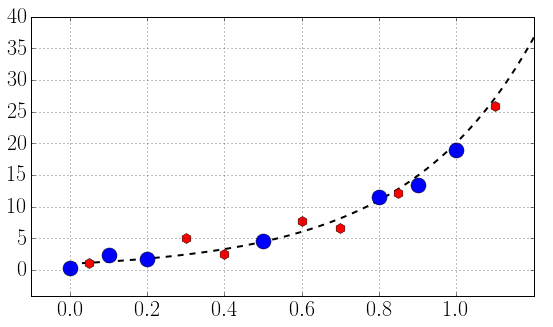

In [5]:
fig = plot_data()
plt.plot(x_ts, y_ts, 'rh', ms=10)
fig

In [6]:
def rms(y_fit, y_test):
    """ Root of mean square deviation """
    return np.sqrt(((y_test - y_fit)**2).mean())

In [7]:
def evaluate_model(model, deg, x_ts=x_ts, y_ts=y_ts):
    y_lrp_ts = model.predict(np.vander(x_ts, deg + 1))
    rmsv = rms(y_lrp_ts, y_ts)
    print('Test RMS: {:.3f}, coef: {:s}'.format(rmsv, ' '.join(['%.2f' % c for c in model.coef_])))
    return rmsv

## Ordinary linear regression

In [8]:
def linear_model(x_tr=x_tr, y_tr=y_tr, x=x, y=y):
    # We create the model.
    lr = lm.LinearRegression()
    # We train the model on our training dataset.
    lr.fit(x[:, np.newaxis], y);
    # Now, we predict points with our trained model.
    y_lr = lr.predict(x_tr[:, np.newaxis])
    evaluate_model(lr, 0)
    return y_lr

In [9]:
def plot_linear_model(y_lr, x_tr=x_tr, y_tr=y_tr, x=x, y=y):
    fig = plot_data(x_tr, y_tr, x, y)
    plt.plot(x_tr, y_lr, 'g', lw=2)
    plt.title("Linear regression")
    return fig

Test RMS: 10.580, coef: 16.65


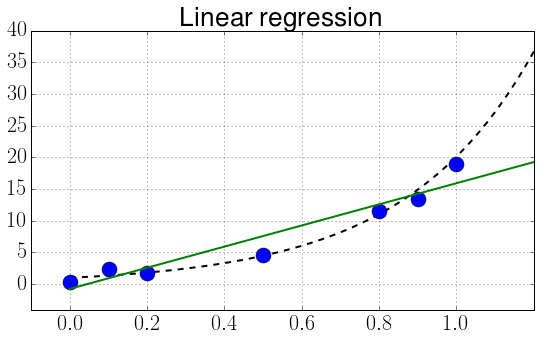

In [10]:
y_lr = linear_model()
plot_linear_model(y_lr)

In [11]:
def without_regularization(x_tr=x_tr, y_tr=y_tr, x=x, y=y):
    lrp = lm.LinearRegression()
    fig = plot_data(x_tr, y_tr, x, y)

    for deg, s in zip([2, 5], ['-', '-']):
        lrp.fit(np.vander(x, deg + 1), y)
        y_lrp = lrp.predict(np.vander(x_tr, deg + 1))
        plt.plot(x_tr, y_lrp, s, label='degree ' + str(deg), lw=2)
        plt.legend(loc=2)
        plt.xlim(-0.1, 1.4)
        plt.ylim(-10, 40)
        evaluate_model(lrp, deg)
    plt.title("Linear regression")
    return fig

Test RMS: 2.131, coef: 19.67 -3.03 0.00
Test RMS: 3.539, coef: 563.07 -1414.71 1245.17 -427.97 53.07 0.00


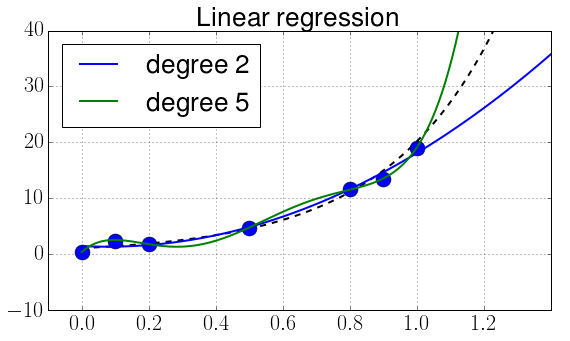

In [12]:
without_regularization()

Linear fit is too biased. The second order polynomial is much better. The fifth order polynomial leads to very high variance. Can we do better?

## Ridge regression
 class sklearn.linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True, normalize=False, scoring=None, cv=None, gcv_mode=None, store_cv_values=False)[source]
 
Ridge regression with built-in cross-validation. By default, it performs Generalized Cross-Validation, which is a form of efficient Leave-One-Out cross-validation.

In [13]:
def with_regularization(x_tr=x_tr, y_tr=y_tr, x=x, y=y):
    ridge = lm.RidgeCV()
    fig = plot_data(x_tr, y_tr, x, y)

    for deg, s in zip([2, 5], ['-', '-']):
        ridge.fit(np.vander(x, deg + 1), y);
        y_ridge = ridge.predict(np.vander(x_tr, deg + 1))
        plt.plot(x_tr, y_ridge, s, label='degree ' + str(deg), lw=2)
        plt.legend(loc=2)
        plt.xlim(-0.1, 1.5)
        plt.ylim(-5, 80)
        # Print the model's coefficients.
        evaluate_model(ridge, deg)
    plt.title("Ridge regression")
    return fig

Test RMS: 2.900, coef: 10.35 5.73 0.00
Test RMS: 1.399, coef: 3.11 3.23 3.41 3.60 3.98 0.00


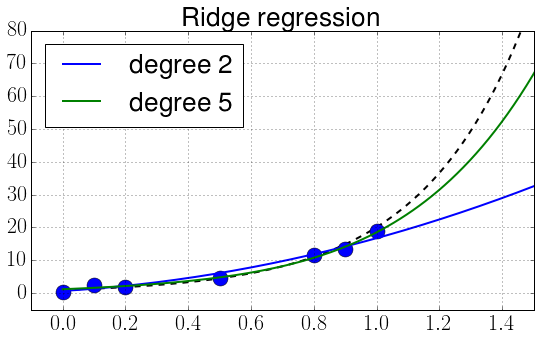

In [14]:
with_regularization()

## Cross validation

In [15]:
def cross_validation(alphas, deg=5, x=x, y=y, x_ts=x_ts, y_ts=y_ts):
    coefs, rms_tr, rms_ts = [], [], []
    for alpha in alphas:
        ridge = lm.Ridge(alpha=alpha)
        ridge.fit(np.vander(x, deg + 1), y)
        y_ridge = ridge.predict(np.vander(x, deg + 1))
        y_ridge_ts = ridge.predict(np.vander(x_ts, deg + 1))
        rms_tr.append(rms(y_ridge, y))
        rms_ts.append(rms(y_ridge_ts, y))
        coefs.append(ridge.coef_[:-1])
    return (coefs, rms_tr, rms_ts)

In [16]:
def plot_rms(alphas, rms_tr, rms_ts):
    fig = plt.figure(figsize=(9, 6))
    plt.plot(alphas, rms_tr, 'bo', label='Train', ms=4)
    plt.plot(alphas, rms_ts, 'ro', label='Test', ms=4)
    plt.semilogx()
    plt.grid()
    plt.gca().set_xlabel(r'$\alpha$')
    plt.gca().set_ylabel('RMS')
    plt.legend(loc='best')
    return fig

In [17]:
def plot_coefs(alphas, coefs, l1=False):
    coefs = np.array(coefs)
    fig = plt.figure(figsize=(9, 6))
    plt.plot(alphas, abs(coefs))
    plt.semilogx()
    if not l1:
        plt.semilogy()
        plt.gca().set_ylabel('Ridge Coefficients')
    else:
        plt.gca().set_ylabel('Lasso Coefficients')
    plt.grid()
    plt.gca().set_xlabel(r'$\alpha$')
    
    return fig

In [18]:
alphas = list(np.logspace(-8, 2))
coefs, rms_tr, rms_ts = cross_validation(alphas)

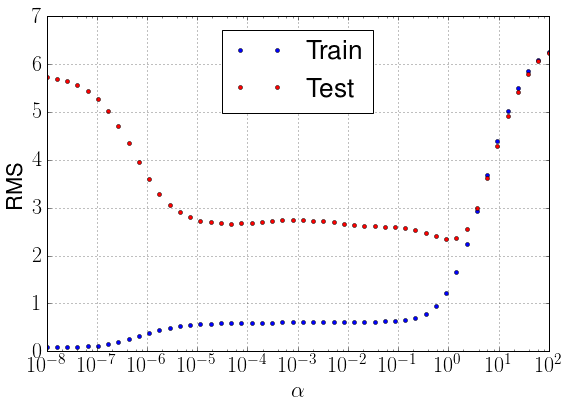

In [19]:
plot_rms(alphas, rms_tr, rms_ts)

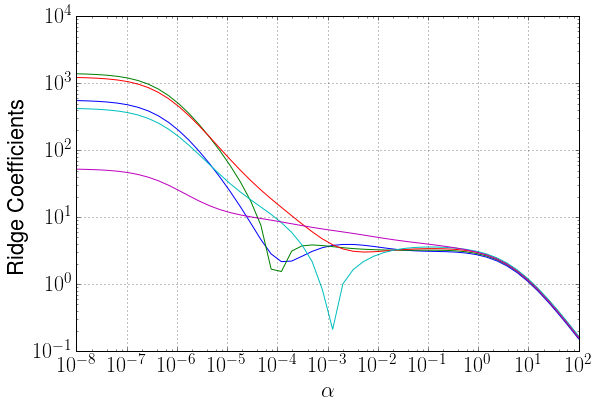

In [20]:
plot_coefs(alphas, coefs)

## Lasso regression

In [21]:
def with_l1_regularization(x_tr=x_tr, y_tr=y_tr, x=x, y=y):
    ridge = lm.LassoCV()
    fig = plot_data(x_tr, y_tr, x, y)

    for deg, s in zip([2, 5], ['-', '-']):
        ridge.fit(np.vander(x, deg + 1), y);
        y_ridge = ridge.predict(np.vander(x_tr, deg + 1))
        plt.plot(x_tr, y_ridge, s, label='degree ' + str(deg), lw=2)
        plt.legend(loc=2)
        plt.xlim(-0.1, 1.5)
        plt.ylim(-5, 80)
        # Print the model's coefficients.
        evaluate_model(ridge, deg)
    plt.title("Lasso regression")
    return fig

Test RMS: 2.192, coef: 18.56 -1.88 0.00
Test RMS: 1.328, coef: 3.34 3.87 4.31 0.00 6.30 0.00


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


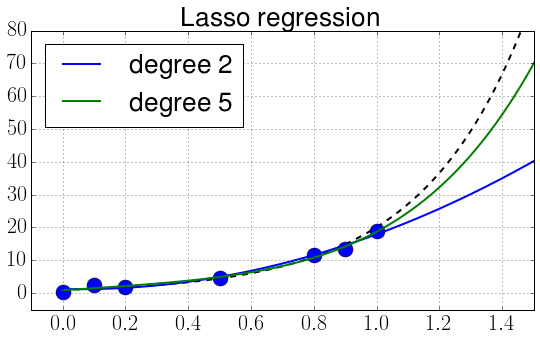

In [22]:
with_l1_regularization()

In [23]:
def cross_validation_l1(alphas, deg=5, x=x, y=y, x_ts=x_ts, y_ts=y_ts):
    coefs, rms_tr, rms_ts = [], [], []
    for alpha in alphas:
        ridge = lm.Lasso(alpha=alpha)
        ridge.fit(np.vander(x, deg + 1), y)
        y_ridge = ridge.predict(np.vander(x, deg + 1))
        y_ridge_ts = ridge.predict(np.vander(x_ts, deg + 1))
        rms_tr.append(rms(y_ridge, y))
        rms_ts.append(rms(y_ridge_ts, y))
        coefs.append(ridge.coef_[:-1])
    return (coefs, rms_tr, rms_ts)

In [24]:
alphas_l1 = list(np.logspace(-1, 1))
coefs_l1, rms_tr_l1, rms_ts_l1 = cross_validation_l1(alphas)

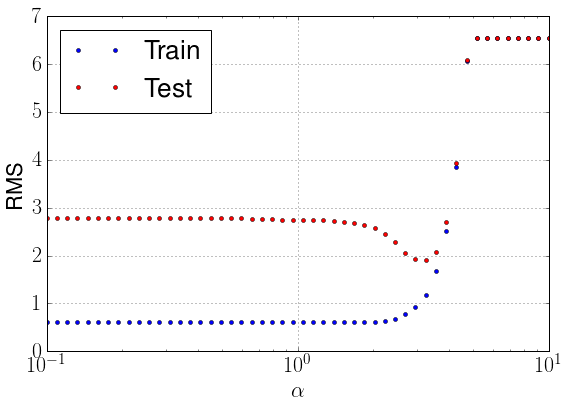

In [25]:
plot_rms(alphas_l1, rms_tr_l1, rms_ts_l1)

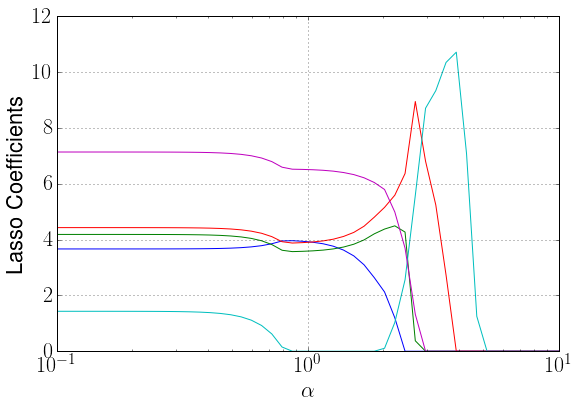

In [26]:
plot_coefs(alphas_l1, coefs_l1, True)